In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("Train set:\n")
print(train_df.head())

Train set:

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


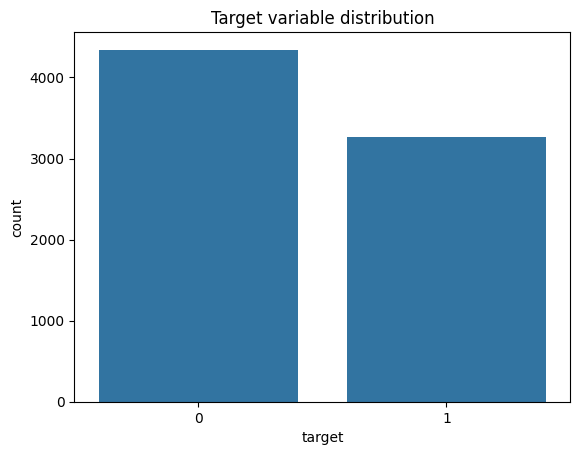


Disaster tweets:
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

Not disaster tweets:
15                  What's up man?
16                   I love fruits
17                Summer is lovely
18               My car is so fast
19    What a goooooooaaaaaal!!!!!!
Name: text, dtype: object

NaN keyword: 61
NaN location: 2533


In [2]:
sns.countplot(x='target', data=train_df)
plt.title('Target variable distribution')
plt.show()

print("\nDisaster tweets:")
print(train_df[train_df['target'] == 1]['text'].head())

print("\nNot disaster tweets:")
print(train_df[train_df['target'] == 0]['text'].head())

print(f"\nNaN keyword: {train_df['keyword'].isnull().sum()}")
print(f"NaN location: {train_df['location'].isnull().sum()}")

In [3]:
import re

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

texts = train_df['clean_text'].values
labels = train_df['target'].values
test_texts = test_df['clean_text'].values

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

maxlen = 50
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
padded_test_sequences = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

print("Original text:", texts[0])
print("Padded sequences:", padded_sequences[0])

Original text: our deeds are the reason of this earthquake may allah forgive us all
Padded sequences: [ 108 4322   21    1  816    5   18  235  122 1532 4323   66   38    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

vocab_size = 10000
embedding_dim = 16

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(
    padded_sequences,
    labels,
    epochs=10,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.6059 - loss: 0.6555 - val_accuracy: 0.7531 - val_loss: 0.5067
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8452 - loss: 0.4113 - val_accuracy: 0.7997 - val_loss: 0.4503
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9091 - loss: 0.2817 - val_accuracy: 0.7597 - val_loss: 0.5182
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9346 - loss: 0.2157 - val_accuracy: 0.7754 - val_loss: 0.5693


In [6]:
predictions = model.predict(padded_test_sequences)
submission_labels = (predictions > 0.5).astype(int)

submission_df = pd.DataFrame({'id': test_df['id'], 'target': submission_labels.flatten()})

submission_df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
